In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.8 MB/s eta 0:00:00


In [45]:
import pennylane as qml
import numpy as np
from IPython.display import display, Markdown

# Devices
dev1 = qml.device("default.qubit", wires=2, shots=1)  # Alice + Eve
dev2 = qml.device("default.qubit", wires=1, shots=1)  # Bob's qubit

# Step 1: Alice creates entangled state, Eve intercepts
@qml.qnode(dev1)
def alice_and_eve(angle_a, eve_basis):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(2 * angle_a, wires=0)

    if eve_basis == "X":
        qml.Hadamard(wires=1)

    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))

# Step 2: Eve resends to Bob, Bob measures
@qml.qnode(dev2)
def bob_measure(eve_result, eve_basis, bob_angle):
    if eve_result == -1:
        qml.PauliX(wires=0)

    if eve_basis == "X":
        qml.Hadamard(wires=0)

    qml.RY(2 * bob_angle, wires=0)
    return qml.sample(qml.PauliZ(0))

# XOR Encryption
def xor_encrypt_decrypt(message, key):
    bin_msg = ''.join(format(ord(c), '08b') for c in message)
    repeated_key = np.resize(key, len(bin_msg))
    encrypted_bits = [int(b) ^ int(k) for b, k in zip(bin_msg, repeated_key)]
    return encrypted_bits

def bits_to_text(bits):
    chars = [chr(int(''.join(map(str, bits[i:i+8])), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)

# Settings
alice_angles = [0, np.pi/4, np.pi/2]
bob_angles   = [np.pi/4, np.pi/2, 3*np.pi/4]
num_trials = 100

raw_key_alice = []
raw_key_bob = []

for _ in range(num_trials):
    a = np.random.randint(3)
    b = np.random.randint(3)

    angle_a = alice_angles[a]
    angle_b = bob_angles[b]
    eve_basis = np.random.choice(["X", "Z"])

    m_a, m_eve = alice_and_eve(angle_a, eve_basis)
    bit_a = int((1 - m_a) / 2)

    m_b = bob_measure(m_eve, eve_basis, angle_b)
    bit_b = int((1 - m_b) / 2)

    if (a == 1 and b == 0) or (a == 2 and b == 1):  # Sifting condition
        raw_key_alice.append(bit_a)
        raw_key_bob.append(bit_b)

# Keys
alice_key = np.array(raw_key_alice)
bob_key = np.array(raw_key_bob)

# Error check
errors = np.sum(alice_key != bob_key)
error_rate = (errors / len(alice_key)) * 100 if len(alice_key) > 0 else 0
eavesdrop_detected = error_rate > 25

# Message encryption from Embassy A to Embassy B
secret_message = "Deploy at 0300 hours"

if not eavesdrop_detected:
    encrypted_bits = xor_encrypt_decrypt(secret_message, bob_key)
    decrypted_bits = xor_encrypt_decrypt(bits_to_text(encrypted_bits), bob_key)
    decrypted_message = bits_to_text(decrypted_bits)
else:
    encrypted_bits = None
    decrypted_message = "❌ Communication Aborted Due to Eavesdropping"

# Display results
display(Markdown("## 🛰️ E91 Quantum Communication: Embassy A ↔️ Embassy B"))
display(Markdown(f"**Key Length (After Sifting):** `{len(alice_key)}`"))
display(Markdown(f"**Alice's Key:** `{''.join(map(str, alice_key))}`"))
display(Markdown(f"**Bob's Key:** `{''.join(map(str, bob_key))}`"))
display(Markdown(f"**Error Rate:** `{error_rate:.2f}%`"))

if not eavesdrop_detected:
    display(Markdown(f"**📡 Embassy A's Secret Message:** `{secret_message}`"))
    display(Markdown(f"**🔐 Encrypted Binary Message (XOR):** `{''.join(map(str, encrypted_bits))}`"))
    display(Markdown(f"**📬 Decrypted at Embassy B:** `{decrypted_message}`"))
    display(Markdown("**✅ Channel is secure. Mission proceeds.**"))
else:
    display(Markdown("**⚠️ Eavesdropping Detected! Secure channel compromised.**"))
    display(Markdown("**❌ Message was NOT sent to Embassy B.**"))


## 🛰️ E91 Quantum Communication: Embassy A ↔️ Embassy B

**Key Length (After Sifting):** `20`

**Alice's Key:** `11110001011101111000`

**Bob's Key:** `11010010011100110000`

**Error Rate:** `25.00%`

**📡 Embassy A's Secret Message:** `Deploy at 0300 hours`

**🔐 Encrypted Binary Message (XOR):** `1001011000010110011111010100101101011111101010110101001101101100010100110001000011100010010000000011110100010111000100001011101000011100011110000101010101000011`

**📬 Decrypted at Embassy B:** `Deploy at 0300 hours`

**✅ Channel is secure. Mission proceeds.**

<ipython-input-46-5ae89a307727>:50: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  ani = animation.FuncAnimation(fig, update, frames=key_length, init_func=init, blit=True, interval=400, repeat=False)
<ipython-input-46-5ae89a307727>:54: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  ani.save(gif_filename, writer=PillowWriter(fps=2))


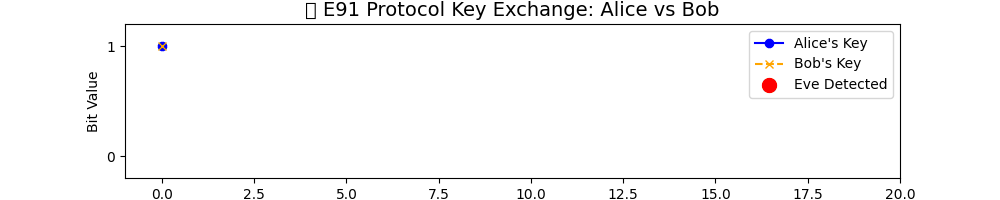

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


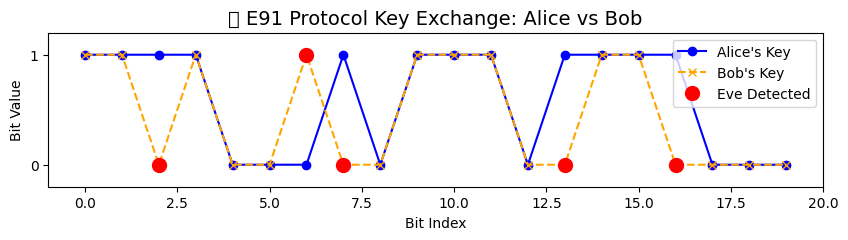

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
from google.colab import files

# Simulated keys for Alice, Bob, and mismatch points (simulating Eve)
key_length = 20
np.random.seed(42)



# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 2))
ax.set_ylim(-0.2, 1.2)
ax.set_xlim(-1, key_length)
ax.set_yticks([0, 1])
ax.set_xlabel("Bit Index")
ax.set_ylabel("Bit Value")
ax.set_title("🔐 E91 Protocol Key Exchange: Alice vs Bob", fontsize=14)

alice_line, = ax.plot([], [], 'o-b', label="Alice's Key")
bob_line,   = ax.plot([], [], 'x--', color='orange', label="Bob's Key")
eve_dots,   = ax.plot([], [], 'ro', markersize=10, label="Eve Detected")

ax.legend(loc='upper right')

def init():
    alice_line.set_data([], [])
    bob_line.set_data([], [])
    eve_dots.set_data([], [])
    return alice_line, bob_line, eve_dots

def update(frame):
    x = np.arange(frame + 1)
    alice_line.set_data(x, alice_key[:frame+1])
    bob_line.set_data(x, bob_key[:frame+1])

    eve_x = []
    eve_y = []
    for i in range(frame + 1):
        if alice_key[i] != bob_key[i]:
            eve_x.append(i)
            eve_y.append(bob_key[i])
    eve_dots.set_data(eve_x, eve_y)

    return alice_line, bob_line, eve_dots

ani = animation.FuncAnimation(fig, update, frames=key_length, init_func=init, blit=True, interval=400, repeat=False)

# Save as GIF
gif_filename = "e91_key_visualization.gif"
ani.save(gif_filename, writer=PillowWriter(fps=2))

# Display GIF
display(Image(gif_filename))

# Download link for Colab
files.download(gif_filename)
